In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from utils.util import load_pickle_file
from utils.future3d_reconstruction_dataset import Future3D_Reconstruction_Dataset

In [2]:
data_root = 'data/Future-3D-Reconstruction'
image_size = 256
batch_size = 1

In [3]:
train_set = Future3D_Reconstruction_Dataset(data_root=os.path.join(data_root, 'train'), image_size=image_size)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)

In [4]:
for i, data in enumerate(train_loader):
    img = data['image']
    mask = data['mask']
    verts = data['vertices']
    normals = data['normals']
    trans = data['translation']
    rot = data['rotation']
    K = data['K']
    for key in data:
        if type(data[key]) is list:
            print(key, data[key])
        else:
            print(key, data[key].size())
    if i >=0:
        break

image torch.Size([1, 3, 256, 256])
mask torch.Size([1, 1, 256, 256])
vertices torch.Size([1, 11930, 3])
normals torch.Size([1, 11930, 3])
translation torch.Size([1, 3])
rotation torch.Size([1, 3, 3])
K torch.Size([1, 3, 3])


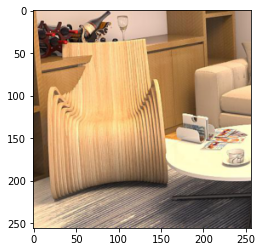

In [5]:
img_vis = (img.cpu().numpy()[0] * 255).astype(np.uint8).transpose(1, 2, 0)
plt.imshow(img_vis)

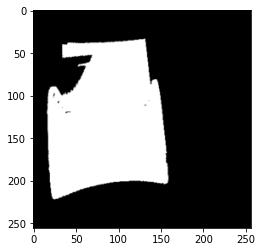

In [6]:
mask_vis = (mask.cpu().numpy()[0][0] * 255).astype(np.uint8)
plt.imshow(mask_vis, cmap='gray')

In [7]:
from utils.commom import project_to_camera

In [8]:
def transform_points(mesh_vertices, trans_vec, rot_mat):
    from scipy.spatial.transform import Rotation as R_
    r_blender = R_.from_matrix(rot_mat)
    x_angle, z_angle, y_angle = r_blender.as_euler('xyz', degrees=True) # xyz ->xzy blender_coordinate -> object coordinate
    r_object = R_.from_euler('yxz', [[-y_angle, 90 - x_angle, z_angle]], degrees=True)
    rot_mat_object = r_object.as_matrix()[0]
    dist = np.sqrt(np.square(trans_vec[0]) + np.square(trans_vec[1]) + np.square(trans_vec[2]))
    trans_vec_object = [0, 0, dist]
    mesh_vertices_trans = np.transpose(np.dot(rot_mat_object, np.transpose(mesh_vertices)))
    mesh_vertices_trans = mesh_vertices_trans - trans_vec_object
    return mesh_vertices_trans

In [9]:
Rt = torch.cat([rot, trans.unsqueeze(2)], dim=2)
print(Rt.size())

torch.Size([1, 3, 4])


In [10]:
print(verts.min(), verts.max())

tensor(-0.4838) tensor(0.9587)


In [11]:
verts_t1 = transform_points(verts.numpy()[0], trans.numpy()[0], rot.numpy()[0])
print(verts_t1[:, :2].min(), verts_t1[:, :2].max())
print(verts_t1.shape)

-0.5343665838369679 0.6669540674418659
(11930, 3)


In [12]:
verts_t1 = torch.from_numpy(verts_t1).float()[None]
print(verts_t1.size())

torch.Size([1, 11930, 3])


In [13]:
print(K)

tensor([[[5.2573e+04, 0.0000e+00, 4.8000e+02],
         [0.0000e+00, 2.9572e+04, 2.7000e+02],
         [0.0000e+00, 0.0000e+00, 1.0000e+00]]])


In [14]:
K_ = np.load('assets/intrinsic.npy')
print(K_.shape)
print(K_)

(3, 3)
[[239.99998474   0.         128.        ]
 [  0.         239.99998474 128.        ]
 [  0.           0.           1.        ]]


In [15]:
def project_to_image(vertices, K, img):
    h_size,w_size, channel = img.shape
    fx = K[0][0]
    fy = K[1][1]
    cx = K[0][2]
    cy = K[0][2]

    # project 3d->2d
    X, Y, Z = vertices.T
    h = (-Y) / (-Z) * fy + cy
    w = X / (-Z) * fx + cx

    # draw projection points
    h = np.minimum(np.maximum(h, 0), h_size - 1)
    w = np.minimum(np.maximum(w, 0), w_size - 1)
    print(h.min(), h.max(), w.min(), w.max())
    img[np.round(h).astype(int), np.round(w).astype(int), :] = (0, 0, 0)
    
    return img

87.459465 156.1885 98.36987 153.30731


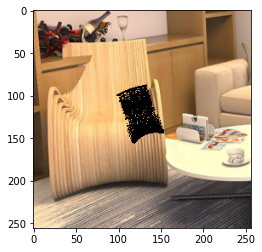

In [16]:
img_vis = project_to_image(verts_t1.numpy()[0], K_, img_vis)
plt.imshow(img_vis)

In [ ]:
verts_t2 = project_to_camera(verts_t1, torch.from_numpy(K_).float()[None])
print(verts_t2.min(), verts_t2.max())
print(verts_t2.size())

In [17]:
def visualise_projection(points_img, img, output_file='./out.png'):
    ''' Visualises the vertex projection to the image plane.
        Args:
            points_img (numpy array): points projected to the image plane
            img (numpy array): image
            output_file (string): where the result should be saved
    '''
    plt.imshow(img.transpose(1, 2, 0))
    plt.plot(
        (points_img[:, 0] + 1)*img.shape[1]/2,
        (points_img[:, 1] + 1) * img.shape[2]/2, 'x')
    plt.savefig(output_file)

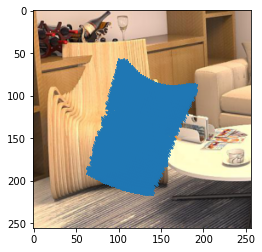

In [18]:
visualise_projection(verts_t1.numpy()[0], img.numpy()[0])